In [1]:
#Importing all required modules & libs
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import regex
import re
import unidecode
import spacy
import emoji
import numpy as np
from numpy import unique
from numpy import where
import pandas as pd
from pandarallel import pandarallel
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import seaborn as sns
import matplotlib._color_data as mcd
import multiprocess
import math
from datetime import datetime
import pytz
from joblib import Memory
import hdbscan
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.manifold import TSNE

In [4]:
#Stop Words
!spacy download es_core_news_sm
nlp = spacy.load('es_core_news_sm')

#Installing required dictionaries
nltk.download('stopwords')
my_stop_words = stopwords.words('spanish')
my_stop_words.extend([',','.','!','#'])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 8.6 MB/s eta 0:00:00m eta 0:00:010:01:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


[nltk_data] Downloading package stopwords to /Users/diego/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
def do_text_cleaning(tweet_text, replace_screen_names, common_words_array):
    # split the string on whitespace
    tweet_text_without_new_lines = tweet_text.replace('\n', ' ')
    out = re.sub(r"del caño","DelCaño", tweet_text_without_new_lines, flags=re.IGNORECASE).split(" ")
    
    # identify urls
    # replace with URL
    out = ['URL' if bool(regex.search("http[s]?://", i)) else i for i in out]
    
    # identify screen names
    # replace with SCREENNAME
    if replace_screen_names :  out = ['SCREENNAME' if i.startswith('@') else i for i in out]

    # remove all punctuation
    out = [regex.sub("[^\\w\\s]|\n", "", i) for i in out]
    
    # remove all numerics
    out = [regex.sub("^[0-9]*$", "", i) for i in out]
    
    # make all non-keywords lowercase
    keys = ['SCREENNAME', 'URL']
    out = [i.lower() if i not in keys else i for i in out]
    
    # remove keywords
    out = [i for i in out if i not in keys]
    
    # Remove stopwords
    out = [i for i in out if i not in my_stop_words]
    
    # Remove known hashtags/common words
    out = [i for i in out if i not in common_words_array]
    
    # lemmatizing
    #out = [do_lemmatizing(i) for i in out]
    
    #remove accents
    out = [unidecode.unidecode(i) for i in out]
    
    # keep words 3 or more characters long
    out = [i for i in out if len(i) >= 3]
    
    return out

In [6]:
#Raw text features

def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI['en'].keys()

def emoji_count(tweet_text):
    emoji_list = [c for c in tweet_text if char_is_emoji(c)]
    return len(emoji_list)

def calculate_mean_emoji_count_per_tweet(tweet_texts):
    pool = multiprocess.Pool(multiprocess.cpu_count())
    emoji_counts = pool.map(emoji_count, tweet_texts)
    pool.close()
    return np.mean(emoji_counts)

def uppercase_word_count(tweet_text):
    splitted_text = tweet_text.split(sep=' ')
    upcase_words = [i for i in splitted_text if i.isupper()]
    return len(upcase_words)

def calculate_mean_uppercase_word_count_per_tweet(tweet_texts):
    pool = multiprocess.Pool(multiprocess.cpu_count())
    uppercase_word_counts = pool.map(uppercase_word_count, tweet_texts)
    pool.close()
    return np.mean(uppercase_word_counts)

def link_count(tweet_text):
    splitted_text = tweet_text.split(" ")
    links = ['URL' for i in splitted_text if bool(regex.search("http[s]?://", i))]
    return len(links)

def calculate_mean_links_count_per_tweet(tweet_texts):
    pool = multiprocess.Pool(multiprocess.cpu_count())
    links_counts = pool.map(link_count, tweet_texts)
    pool.close()
    return np.mean(links_counts)

def word_is_hashtag(word):
    return(len(word) > 0 and word[0] == '#')

def hashtag_count(tweet_text):
    splitted_text = tweet_text.split(" ")
    hashtags = [word for word in splitted_text if word_is_hashtag(word)]
    return len(hashtags)

def calculate_mean_hashtag_count_per_tweet(tweet_texts):
    pool = multiprocess.Pool(multiprocess.cpu_count())
    hashtags_counts = pool.map(hashtag_count, tweet_texts)
    pool.close()
    return np.mean(hashtags_counts)

def word_is_user_mention(word):
    return(len(word) > 0 and word[0] == '@')

def user_mention_count(tweet_text):
    splitted_text = tweet_text.split(" ")
    user_mentions = [word for word in splitted_text if word_is_user_mention(word)]
    return len(user_mentions)

def calculate_mean_user_mention_count_per_tweet(tweet_texts):
    pool = multiprocess.Pool(multiprocess.cpu_count())
    user_mention_counts = pool.map(user_mention_count, tweet_texts)
    pool.close()
    return np.mean(user_mention_counts)

def calculate_raw_text_features(user_df, tweet_data_df):
    mean_user_mention_count_per_tweet = []
    mean_hashtag_count_per_tweet = []
    mean_capitalized_word_count_per_tweet = []
    mean_link_count_per_tweet = []
    mean_emoji_count_per_tweet = []
    for user_row in user_df.itertuples():
        user_db_id = user_row.DBID
        user_tweets = tweet_data_df[tweet_data_df['User DB ID'] == user_db_id]
        user_tweets_text = list(user_tweets.loc[:,'Text'])
        mean_user_mention_count_per_tweet.append(calculate_mean_user_mention_count_per_tweet(user_tweets_text))
        mean_hashtag_count_per_tweet.append(calculate_mean_hashtag_count_per_tweet(user_tweets_text))
        mean_capitalized_word_count_per_tweet.append(calculate_mean_uppercase_word_count_per_tweet(user_tweets_text))
        mean_link_count_per_tweet.append(calculate_mean_links_count_per_tweet(user_tweets_text))
        mean_emoji_count_per_tweet.append(calculate_mean_emoji_count_per_tweet(user_tweets_text))
    return(mean_user_mention_count_per_tweet, mean_hashtag_count_per_tweet, mean_capitalized_word_count_per_tweet, mean_link_count_per_tweet, mean_emoji_count_per_tweet)

In [51]:
#Vector features

def calculate_similarities_for_tweet_list(tweet_ids_list, keyed_vectors, topn):
    all_tweets_similarities = []
    for tweet_id in tweet_ids_list:
        similarity_scores = [x[1] for x in keyed_vectors.similar_by_key(tweet_id, topn)]
        all_tweets_similarities.append(similarity_scores)
    return all_tweets_similarities

def calculate_doc2vec_features_for_user(user_id, tweet_data, keyed_vectors, topn):
    tweets_indexes = tweet_data[tweet_data['User DB ID']==user_id].index.to_list()
    
    similarities = calculate_similarities_for_tweet_list(tweets_indexes, keyed_vectors, topn)

    max_similarity = np.max(similarities)
    min_similarity = np.min(similarities)
    similarty_variance = np.var(similarities)
    similarity_median = np.median(similarities)
    return(max_similarity, min_similarity, similarty_variance, similarity_median)

In [94]:
#Tweet Ratio features
def original_tweet_ratio(user_dbid, tweet_data_df):
    user_tweets = tweet_data_df[tweet_data_df['User DB ID']==user_dbid]
    total_user_tweets = user_tweets.count()[0]
    original_count = user_tweets[user_tweets['Type']=='Original'].count()[0]
    return(original_count/total_user_tweets)

def retweet_ratio(user_dbid, tweet_data_df):
    user_tweets = tweet_data_df[tweet_data_df['User DB ID']==user_dbid]
    total_user_tweets = user_tweets.count()[0]
    original_count = user_tweets[user_tweets['Type']=='Retweet'].count()[0]
    return(original_count/total_user_tweets)

def replies_tweet_ratio(user_dbid, tweet_data_df):
    user_tweets = tweet_data_df[tweet_data_df['User DB ID']==user_dbid]
    total_user_tweets = user_tweets.count()[0]
    original_count = user_tweets[user_tweets['Type']=='Reply'].count()[0]
    return(original_count/total_user_tweets)

def quote_tweet_ratio(user_dbid, tweet_data_df):
    user_tweets = tweet_data_df[tweet_data_df['User DB ID']==user_dbid]
    total_user_tweets = user_tweets.count()[0]
    original_count = user_tweets[user_tweets['Type']=='Quote'].count()[0]
    return(original_count/total_user_tweets)

In [8]:
def validate_if_user_tweeted_in_debate(user_df, tweet_data_df):
    tweeted = []
    for user_row in user_df.itertuples():
        user_db_id = user_row.DBID
        user_tweets = tweet_data_df[tweet_data_df['User DB ID'] == user_db_id]
        tweeted.append(len(user_tweets) > 0)
    return tweeted

In [9]:
#Importing and splitting dataset
#Tweet export files can not be public to honor deleted tweets (more info no https://developer.twitter.com/en/developer-terms/policy)
#

#Loading Tweets
tweet_csv_file = '<path_to_tweet_export_file>'
users_csv_file = '<path_to_users_export_file>'
original_tweet_data = pd.read_csv(tweet_csv_file, sep=';')
original_user_data = pd.read_csv(users_csv_file, sep=';')

#Making a working copy
tweet_data = original_tweet_data.copy()
user_data = original_user_data.copy()

#Removing Tweets with no text, probably there was an error while capturing them
tweet_data.dropna(axis=0, how='any', subset = ['Text'], inplace = True)

# Converting text into dates
tweet_data['Creation Date'] = pd.to_datetime(tweet_data['Creation Date'], format="%Y-%m-%d %H:%M:%S %Z")

# Splitting Tweet datasets in 2. One for each debate. First debate will be used as training data, second as test.
utc = pytz.UTC
second_debate_date = utc.localize(datetime.strptime('2019-10-20 00:00:00', "%Y-%m-%d %H:%M:%S"))
first_debate_tweet_data = tweet_data.query("`Creation Date` < @second_debate_date")
second_debate_tweet_data = tweet_data.query("`Creation Date` >= @second_debate_date")

user_tweeted_in_first_debate = validate_if_user_tweeted_in_debate(user_data, first_debate_tweet_data)
user_tweeted_in_second_debate = validate_if_user_tweeted_in_debate(user_data, second_debate_tweet_data)
user_data['Tweeted in First Debate'] = user_tweeted_in_first_debate
user_data['Tweeted in Second Debate'] = user_tweeted_in_second_debate
first_debate_user_data = user_data.query("`Tweeted in First Debate` == True").copy()
second_debate_user_data = user_data.query("`Tweeted in Second Debate` == True").copy()

#Resetting indexes
first_debate_tweet_data.reset_index(drop=True, inplace=True)
second_debate_tweet_data.reset_index(drop=True, inplace=True)
first_debate_user_data.reset_index(drop=True, inplace=True)
second_debate_user_data.reset_index(drop=True, inplace=True)

In [10]:
# Cleaning text
common_words_array = []
replace_screen_names = False
pandarallel.initialize(progress_bar=True)
first_debate_tweet_data['Clean Text'] = first_debate_tweet_data['Text'].parallel_apply(do_text_cleaning, args=(replace_screen_names, common_words_array))

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/var/folders/vf/ht4mywc50_v3sl6df6g_mkm00000gn/T/ipykernel_18272/3694375819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_debate_tweet_data['Clean Text'] = first_debate_tweet_data['Text'].parallel_apply(do_text_cleaning, args=(replace_screen_names, common_words_array))


In [13]:
#calculate pre_text_cleaning_features for 1st debate
mean_user_mention_count_per_tweet, mean_hashtag_count_per_tweet, mean_capitalized_word_count_per_tweet, mean_link_count_per_tweet, mean_emoji_count_per_tweet = calculate_raw_text_features(first_debate_user_data, first_debate_tweet_data)

Traceback (most recent call last):
Process ForkPoolWorker-4163623:
Process ForkPoolWorker-4369265:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-4078523:
  File "/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):


In [15]:
first_debate_user_data['Mean User Mentions'] = mean_user_mention_count_per_tweet
first_debate_user_data['Mean Hashtags'] = mean_hashtag_count_per_tweet
first_debate_user_data['Mean Capitalized Words'] = mean_capitalized_word_count_per_tweet
first_debate_user_data['Mean Links'] = mean_link_count_per_tweet
first_debate_user_data['Mean Emojis'] = mean_emoji_count_per_tweet

In [29]:
#Saving first_debate_user_data Dataframe so far so we do not have to recompute in case of failure
first_debate_user_data.to_pickle('first_debate_user_data')
first_debate_tweet_data.to_pickle('first_debate_tweet_data')

In [20]:
#Calculate Vectorized Features
cores = multiprocess.cpu_count()
first_debate_tweet_data_clean_text_list = first_debate_tweet_data['Clean Text'].to_list()
first_debate_tweet_tagged_data = [TaggedDocument(d, [str(i)]) for i, d in enumerate(first_debate_tweet_data_clean_text_list)]
first_debate_tweet_data_model = gensim.models.doc2vec.Doc2Vec(vector_size=300, min_count=1, sample=1e-5, epochs=100, hs=0, dm=0, negative=5, workers=cores)
first_debate_tweet_data_model.build_vocab(first_debate_tweet_tagged_data)
first_debate_tweet_data_model.train(first_debate_tweet_tagged_data, total_examples=first_debate_tweet_data_model.corpus_count, epochs=100)
first_debate_tweet_data_model.save('tesis_first_debate_tweet_data_model.model')

In [52]:
topn = math.floor(first_debate_tweet_data_model.corpus_count * .01)
document_features = first_debate_user_data['DBID'].parallel_apply(calculate_doc2vec_features_for_user, args=(first_debate_tweet_data, first_debate_tweet_data_model.dv, topn))

/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


In [75]:
document_features_df = pd.DataFrame(document_features.tolist(), index=document_features.index, columns=['max_similarity', 'min_similarity', 'similarty_variance', 'similarity_median'])

In [76]:
first_debate_user_data['max_similarity'] = document_features_df['max_similarity']
first_debate_user_data['min_similarity'] = document_features_df['min_similarity']
first_debate_user_data['similarty_variance'] = document_features_df['similarty_variance']
first_debate_user_data['similarity_median'] = document_features_df['similarity_median']

In [78]:
first_debate_user_data.to_pickle('first_debate_user_data_with_raw_and_vec_features')

In [99]:
#Calculate tweet ratio features
first_debate_user_data['original_tweet_ratio'] = first_debate_user_data['DBID'].parallel_apply(original_tweet_ratio,args=(first_debate_tweet_data,))
first_debate_user_data['retweet_ratio'] = first_debate_user_data['DBID'].parallel_apply(retweet_ratio,args=(first_debate_tweet_data,))
first_debate_user_data['replies_tweet_ratio'] = first_debate_user_data['DBID'].parallel_apply(replies_tweet_ratio,args=(first_debate_tweet_data,))
first_debate_user_data['quote_tweet_ratio'] = first_debate_user_data['DBID'].parallel_apply(quote_tweet_ratio,args=(first_debate_tweet_data,))

/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


In [101]:
## Transforming booleans to integers
first_debate_user_data['DefaultProfileImage'] = user_data['DefaultProfileImage'].map({True: 1, False: 0})
first_debate_user_data['VerifiedAccount'] = user_data['VerifiedAccount'].map({True: 1, False: 0})

In [122]:
#Normalizing values so it fits the range 0-1
first_debate_user_data['Followers'] = (first_debate_user_data['Followers'] - np.min(first_debate_user_data['Followers'])) / (np.max(first_debate_user_data['Followers']) - np.min(first_debate_user_data['Followers']))
first_debate_user_data['Mean User Mentions'] = (first_debate_user_data['Mean User Mentions'] - np.min(first_debate_user_data['Mean User Mentions'])) / (np.max(first_debate_user_data['Mean User Mentions']) - np.min(first_debate_user_data['Mean User Mentions']))
first_debate_user_data['Mean Hashtags'] = (first_debate_user_data['Mean Hashtags'] - np.min(first_debate_user_data['Mean Hashtags'])) / (np.max(first_debate_user_data['Mean Hashtags']) - np.min(first_debate_user_data['Mean Hashtags']))
first_debate_user_data['Mean Capitalized Words'] = (first_debate_user_data['Mean Capitalized Words'] - np.min(first_debate_user_data['Mean Capitalized Words'])) / (np.max(first_debate_user_data['Mean Capitalized Words']) - np.min(first_debate_user_data['Mean Capitalized Words']))
first_debate_user_data['Mean Links'] = (first_debate_user_data['Mean Links'] - np.min(first_debate_user_data['Mean Links'])) / (np.max(first_debate_user_data['Mean Links']) - np.min(first_debate_user_data['Mean Links']))
first_debate_user_data['Mean Emojis'] = (first_debate_user_data['Mean Emojis'] - np.min(first_debate_user_data['Mean Emojis'])) / (np.max(first_debate_user_data['Mean Emojis']) - np.min(first_debate_user_data['Mean Emojis']))
first_debate_user_data['max_similarity'] = (first_debate_user_data['max_similarity'] - np.min(first_debate_user_data['max_similarity'])) / (np.max(first_debate_user_data['max_similarity']) - np.min(first_debate_user_data['max_similarity']))
first_debate_user_data['min_similarity'] = (first_debate_user_data['min_similarity'] - np.min(first_debate_user_data['min_similarity'])) / (np.max(first_debate_user_data['min_similarity']) - np.min(first_debate_user_data['min_similarity']))
first_debate_user_data['similarty_variance'] = (first_debate_user_data['similarty_variance'] - np.min(first_debate_user_data['similarty_variance'])) / (np.max(first_debate_user_data['similarty_variance']) - np.min(first_debate_user_data['similarty_variance']))
first_debate_user_data['similarity_median'] = (first_debate_user_data['similarity_median'] - np.min(first_debate_user_data['similarity_median'])) / (np.max(first_debate_user_data['similarity_median']) - np.min(first_debate_user_data['similarity_median']))


In [132]:
first_debate_user_data.to_pickle('first_debate_user_data_final')

In [125]:
first_debate_user_data_numeric_only = first_debate_user_data.loc[:,['DefaultProfileImage','Followers','VerifiedAccount','Mean User Mentions','Mean Hashtags','Mean Capitalized Words','Mean Links','Mean Emojis','max_similarity','min_similarity','similarty_variance','similarity_median','original_tweet_ratio','retweet_ratio','replies_tweet_ratio','quote_tweet_ratio']]

In [127]:
first_debate_user_data_numeric_only.to_pickle('first_debate_user_data_numeric_only')

In [173]:
#this cell was run multiple times with different values
#the result has been documented on the Tesis Document
mem = Memory(location='joblib')
best_dbcv_score = -2
best_min_samples_param = -1
best_min_cluster_sizes_param = -1
best_cluster_selection_method_param = ''
best_metric_param = ''
    
# specify parameters and distributions to sample from
param_dist = {'min_samples': [350,400,450],
              'min_cluster_sizes':[850,950,1050],  
              'cluster_selection_methods' : ['eom','leaf'],
              'metrics' : ['euclidean','manhattan'] 
             }

for min_sample_size in param_dist['min_samples']:
    for min_cluster_size in param_dist['min_cluster_sizes']:
        for cluster_selection_method in param_dist['cluster_selection_methods']:
            for metric in param_dist['metrics']:
                print("min_sample_size: " + str(min_sample_size) + " min_cluster_size: " + str(min_cluster_size) + " cluster_selection_method: " + str(cluster_selection_method) + " metric: " + str(metric))
                clusterer = hdbscan.HDBSCAN(core_dist_n_jobs=1, gen_min_span_tree=True, min_cluster_size=min_cluster_size, min_samples=min_sample_size, cluster_selection_method=cluster_selection_method, metric=metric, memory=mem)
                hdb = clusterer.fit(first_debate_user_data_numeric_only)
                dbcv_score = clusterer.relative_validity_
                print(f"DBCV score {dbcv_score}")
                if dbcv_score > best_dbcv_score:
                    best_dbcv_score = dbcv_score
                    best_min_samples_param = min_sample_size
                    best_min_cluster_sizes_param = min_cluster_size
                    best_cluster_selection_method_param = cluster_selection_method
                    best_metric_param = metric
    
    
print("best_dbcv_score: " +  str(best_dbcv_score))
print("best_min_samples_param: " +  str(best_min_samples_param))
print("best_min_cluster_sizes_param: " +  str(best_min_cluster_sizes_param))
print("best_cluster_selection_method_param: " +  best_cluster_selection_method_param)
print("best_metric_param: " +  best_metric_param)

min_sample_size: 350 min_cluster_size: 850 cluster_selection_method: eom metric: euclidean
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), 350, 1.0, 'euclidean', None, 40, True, True, 1)
_________________________________________hdbscan_boruvka_kdtree - 266.4s, 4.4min
DBCV score 0.39745244159407683
min_sample_size: 350 min_cluster_size: 850 cluster_selection_method: eom metric: manhattan
________________________________________________________________________________
[Memory] Calling hdbscan.hdbscan_._hdbscan_boruvka_kdtree...
_hdbscan_boruvka_kdtree(array([[0., ..., 0.],
       ...,
       [0., ..., 0.]]), 350, 1.0, 'manhattan', None, 40, True, True, 1)
_________________________________________hdbscan_boruvka_kdtree - 302.0s, 5.0min
DBCV score 0.13443482723313493
min_sample_size: 350 min_cluster_size: 850 cluster

In [2]:
first_debate_user_data = pd.read_pickle('first_debate_user_data_final')
first_debate_user_data_numeric_only = pd.read_pickle('first_debate_user_data_numeric_only')

In [3]:
#Using best configuration found
mem = Memory(location='joblib')
min_samples =  300
min_cluster_size = 1000
cluster_selection_method = 'eom'
metric = 'euclidean'
best_clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True, min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_method=cluster_selection_method, metric=metric, memory=mem)
best_hdb = best_clusterer.fit(first_debate_user_data_numeric_only)

In [4]:
# Get info about the cluster
labels = best_clusterer.labels_
clustered = (labels >= 0)

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ['cluster','count']
print(cnts.sort_values(['cluster']))

coverage = np.sum(clustered) / first_debate_user_data_numeric_only.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {best_clusterer.relative_validity_}")
print(f"Clusters: {best_clusterer.labels_.max()}")

    cluster  count
0        -1  55741
6         0   3363
3         1   8044
10        2   1503
8         3   2026
7         4   2226
4         5   5284
2         6  11882
9         7   1737
1         8  13231
5         9   3505
11       10   1272
Coverage 0.4924053399384414
DBCV score 0.4283477306807637
Clusters: 10


<AxesSubplot: ylabel='$\\lambda$ value'>

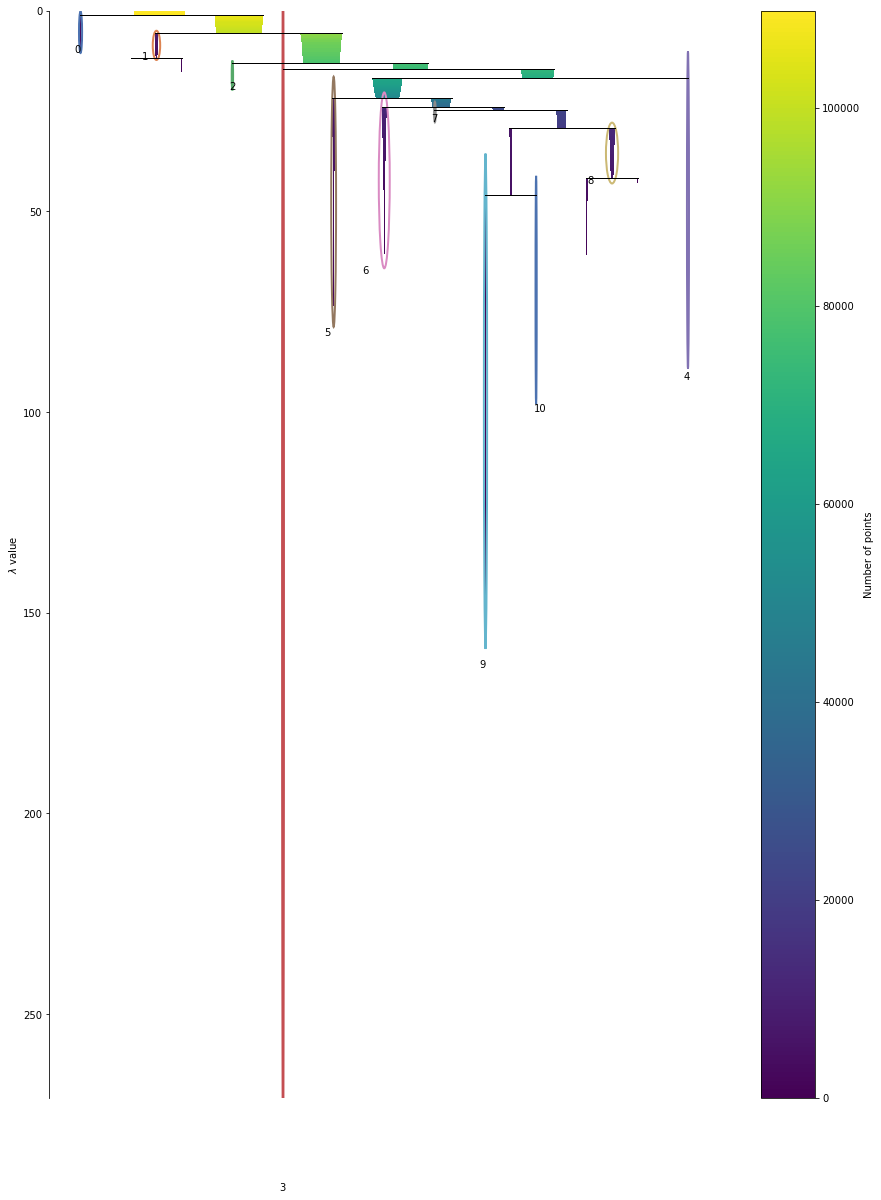

In [5]:
labels = best_clusterer.labels_
_, ax = plt.subplots(figsize=(15,20)) # Resize figure
best_clusterer.condensed_tree_.plot(
    select_clusters=True,
    label_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(labels).shape[0]),
)

In [23]:
tsne = TSNE(random_state=42, verbose=2, perplexity=30, learning_rate='auto', n_iter=2000, n_jobs=-1)
tsne_data = tsne.fit_transform(first_debate_user_data_numeric_only)

/Users/diego/opt/anaconda3/envs/tesis/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 109814 samples in 0.002s...
[t-SNE] Computed neighbors for 109814 samples in 626.131s...
[t-SNE] Computed conditional probabilities for sample 1000 / 109814
[t-SNE] Computed conditional probabilities for sample 2000 / 109814
[t-SNE] Computed conditional probabilities for sample 3000 / 109814
[t-SNE] Computed conditional probabilities for sample 4000 / 109814
[t-SNE] Computed conditional probabilities for sample 5000 / 109814
[t-SNE] Computed conditional probabilities for sample 6000 / 109814
[t-SNE] Computed conditional probabilities for sample 7000 / 109814
[t-SNE] Computed conditional probabilities for sample 8000 / 109814
[t-SNE] Computed conditional probabilities for sample 9000 / 109814
[t-SNE] Computed conditional probabilities for sample 10000 / 109814
[t-SNE] Computed conditional probabilities for sample 11000 / 109814
[t-SNE] Computed conditional probabilities for sample 12000 / 109814
[t-SNE] Computed conditional proba

[t-SNE] Iteration 250: error = 92.2288361, gradient norm = 0.0007795 (50 iterations in 60.366s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.228836
[t-SNE] Iteration 300: error = 4.3381124, gradient norm = 0.0004122 (50 iterations in 57.706s)
[t-SNE] Iteration 350: error = 3.5593951, gradient norm = 0.0002259 (50 iterations in 55.701s)
[t-SNE] Iteration 400: error = 3.0838346, gradient norm = 0.0001480 (50 iterations in 56.522s)
[t-SNE] Iteration 450: error = 2.7659144, gradient norm = 0.0001084 (50 iterations in 56.687s)
[t-SNE] Iteration 500: error = 2.5404065, gradient norm = 0.0000867 (50 iterations in 55.393s)
[t-SNE] Iteration 550: error = 2.3768854, gradient norm = 0.0000720 (50 iterations in 54.931s)
[t-SNE] Iteration 600: error = 2.2534320, gradient norm = 0.0000615 (50 iterations in 54.863s)
[t-SNE] Iteration 650: error = 2.1566007, gradient norm = 0.0000539 (50 iterations in 55.304s)
[t-SNE] Iteration 700: error = 2.0781093, gradient norm = 0.000048

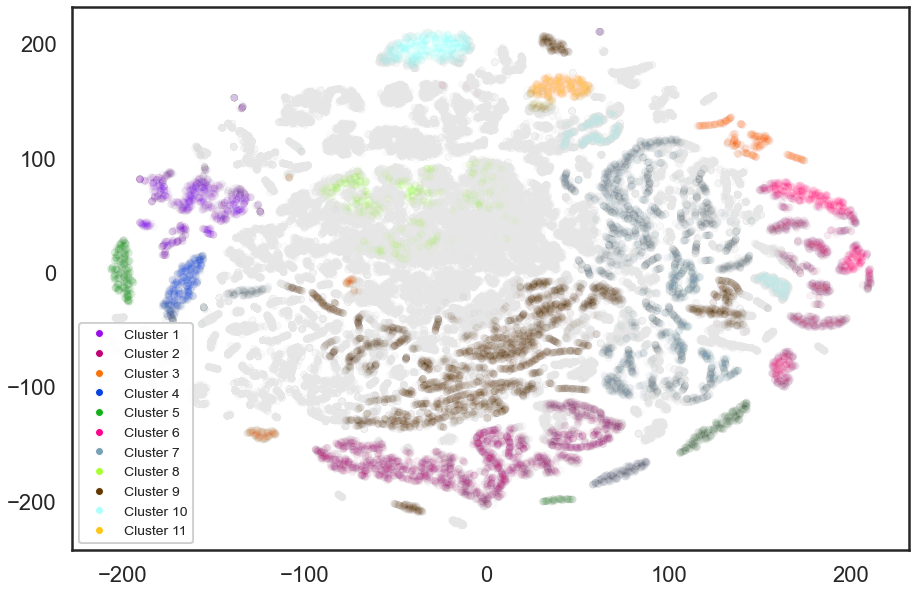

In [138]:
plot_kwds = {'alpha' : 0.01, 's' : 50, 'linewidths':0.5}

labels = best_clusterer.labels_

xkcd_color_selection=['violet', 'magenta','orange','blue', 'green', 'hot pink', 'greyblue', 'lime', 'brown', 'light cyan', 'golden yellow']
cluster_colors = sns.xkcd_palette(xkcd_color_selection)

fig, ax = plt.subplots(figsize=(15, 10))

data_points_colors = [sns.desaturate(cluster_colors[col], sat)
                  if col >= 0 else (0.9, 0.9, 0.9) for col, sat in
                  zip(labels, best_clusterer.probabilities_)]
    

scatter = ax.scatter(*tsne_data.T, c=data_points_colors, **plot_kwds)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
                          markerfacecolor=mcolor, markersize=8) for i, mcolor in enumerate(cluster_colors)]
legend = ax.legend(handles=legend_elements, loc="lower left", fontsize='xx-small')
ax.add_artist(legend)
plt.show()
